In [14]:
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import matplotlib as mpl
import imageio
from scipy import interpolate
from scipy import optimize
from scipy.signal import convolve
from skimage.filters import gaussian
plt.style.use(['science', 'notebook'])
import tomopy
import functions
import pandas as pd
import json

from scipy.interpolate import RectBivariateSpline
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale, rotate
from skimage.measure import profile_line

def get_gaus_kernel(n, sig):
    xv, yv = np.meshgrid(np.arange(n), np.arange(n))
    xv = xv - xv.max()/2
    yv = yv -  yv.max()/2
    gaus_kernel = 1/np.sqrt(2*np.pi*sig**2) * np.exp(-(xv**2+yv**2)/(2*sig**2))
    return gaus_kernel/gaus_kernel.sum()

Define mean of Poisson distribution and dimensions of image

In [15]:
lam = 500
n = 400
L_val = 1/2
B_val = 1/5

Read original CT image and normalize to get reasonable attenuation coefficient $\mu(x,y)$

In [16]:
A1 = imageio.imread('images/phantom1.png').sum(axis=2)
A2 = imageio.imread('images/phantom2.png').sum(axis=2)
A3 = imageio.imread('images/phantom3.png').sum(axis=2)
A4 = imageio.imread('images/phantom4.png').sum(axis=2)
A1_norm = functions.normalize_phantom(A1)
A2_norm = functions.normalize_phantom(A2)
A3_norm = functions.normalize_phantom(A3)
A4_norm = functions.normalize_phantom(A4)

A = A1
A_norm = A1_norm

Get all tumours and append to single array

In [17]:
Ts = np.array([np.asarray(imageio.imread(f'images/t{i}.png').sum(axis=2) > 0) for i in range(1,24)])
n = A1.shape[0]
T = Ts.sum(axis=0).astype(bool)
T_masked = np.ma.masked_where(~T, T)

Add live and background and remove any overlapping tumours from liver

In [18]:
L = np.asarray(imageio.imread(f'images/liv.png').sum(axis=2))>260
B = np.asarray(imageio.imread(f'images/background.png').sum(axis=2))>260

Ts_non_overlap = []
for T in Ts:
    if not np.any(T*L):
        Ts_non_overlap.append(T)
T = np.array(Ts_non_overlap).sum(axis=0).astype(bool)
T_masked = np.ma.masked_where(~T, T)
B = B^(T+L)

In [19]:
T_masked = np.ma.masked_where(~T, T)
L_masked = np.ma.masked_where(~L, L)
B_masked = np.ma.masked_where(~B, B)
masks = [T_masked, L_masked, B_masked]
mask_names = ['T', 'L', 'B']

Get tumour distribution by smoothing the activity.

In [20]:
U = functions.get_tumour_dist(T, sigma=3)
U[L] += L_val
U[B] += B_val

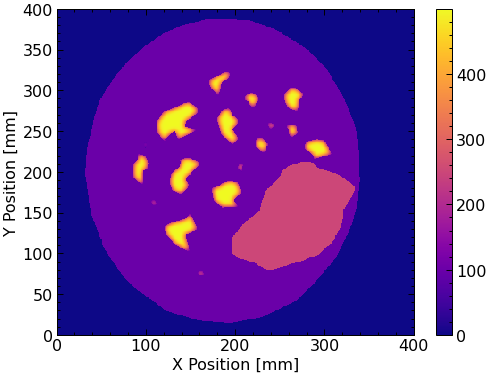

In [21]:
plt.pcolormesh(500*U, cmap='plasma')
plt.xlabel('X Position [mm]')
plt.ylabel('Y Position [mm]')
plt.colorbar()

Get original PET image along with decay points $(x,y)$ and corresponding decay angles $\theta$.

In [22]:
''' Only run first time '''
#PET_og, dpoints, dangles = functions.get_original_PET(U, T+L+B, lam=lam)
#prob_of_detections1 = functions.compute_prob_of_detections(A1_norm, dpoints, dangles, n=A1.shape[0])
#np.savez("tumour_dist_P1_livback.npz", PET_og=PET_og, dpoints=dpoints, dangles=dangles, prob_of_detections=prob_of_detections1)
#prob_of_detections2 = functions.compute_prob_of_detections(A2_norm, dpoints, dangles, n=A1.shape[0])
#np.savez("tumour_dist_P2_livback.npz", PET_og=PET_og, dpoints=dpoints, dangles=dangles, prob_of_detections=prob_of_detections2)
#prob_of_detections3 = functions.compute_prob_of_detections(A3_norm, dpoints, dangles, n=A1.shape[0])
#np.savez("tumour_dist_P3_livback.npz", PET_og=PET_og, dpoints=dpoints, dangles=dangles, prob_of_detections=prob_of_detections3)
#prob_of_detections4 = functions.compute_prob_of_detections(A4_norm, dpoints, dangles, n=A1.shape[0])
#np.savez("tumour_dist_P4_livback.npz", PET_og=PET_og, dpoints=dpoints, dangles=dangles, prob_of_detections=prob_of_detections4)
dfile = np.load('tumour_dist_P1_livback.npz')
PET_og, dpoints, dangles, prob_of_detections = dfile['PET_og'], dfile['dpoints'], dfile['dangles'], dfile['prob_of_detections']

Get the attenuated PET image by removing certain events according to their probability of attenuation

In [23]:
PET_att, mask_att = functions.get_attenuated_PET(dpoints, dangles, prob_of_detections, n=n)

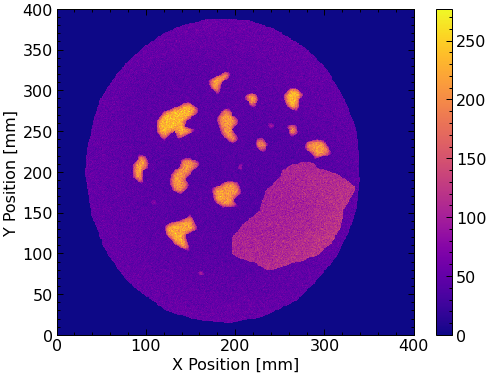

In [24]:
plt.pcolormesh(PET_att, cmap='plasma')
plt.xlabel('X Position [mm]')
plt.ylabel('Y Position [mm]')
plt.colorbar()

Get corresponding sinograms

In [26]:
sino, rs, thetas =  functions.get_sinogram(dpoints, dangles)
sino_att, _, _ =  functions.get_sinogram(dpoints, dangles, mask=mask_att)

In [29]:
thetas

array([0.        , 0.10471976, 0.20943951, 0.31415927, 0.41887902,
       0.52359878, 0.62831853, 0.73303829, 0.83775804, 0.9424778 ,
       1.04719755, 1.15191731, 1.25663706, 1.36135682, 1.46607657,
       1.57079633, 1.67551608, 1.78023584, 1.88495559, 1.98967535,
       2.0943951 , 2.19911486, 2.30383461, 2.40855437, 2.51327412,
       2.61799388, 2.72271363, 2.82743339, 2.93215314, 3.0368729 ,
       3.14159265, 3.24631241, 3.35103216, 3.45575192, 3.56047167,
       3.66519143, 3.76991118, 3.87463094, 3.97935069, 4.08407045,
       4.1887902 , 4.29350996, 4.39822972, 4.50294947, 4.60766923,
       4.71238898, 4.81710874, 4.92182849, 5.02654825, 5.131268  ,
       5.23598776, 5.34070751, 5.44542727, 5.55014702, 5.65486678,
       5.75958653, 5.86430629, 5.96902604, 6.0737458 , 6.17846555,
       6.28318531])

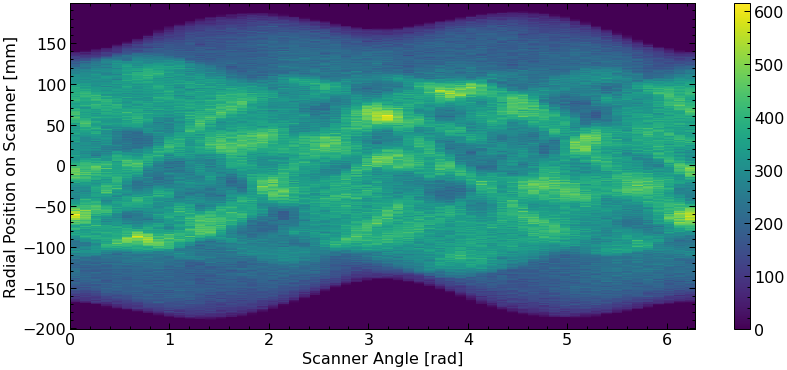

In [35]:
plt.figure(figsize=(14,6))
plt.pcolormesh(thetas, rs, sino_att)
plt.ylabel('Radial Position on Scanner [mm]')
plt.xlabel('Scanner Angle [rad]')
plt.colorbar()

# Reconstruction

Get a matrix that gives the probability of an event being detected for each $(x,y)$ value

In [12]:
def estimate_prob_of_detections_rtheta(rs, thetas, A, num=1000):
    n = A.shape[0]
    diameter = np.sqrt(2*n**2)
    # from histogram edges to centers
    thetas = thetas[:-1]+np.diff(thetas)[0]/2
    rs = rs[:-1]+0.5
    print(len(rs))
    prob_of_detections = np.zeros([len(rs),len(thetas)])
    for i,r in enumerate(rs):
        for j,theta in enumerate(thetas):
            x = r*np.cos(theta+np.pi/2) + n//2
            y = r*np.sin(theta+np.pi/2) + n//2
            x1 = x - np.cos(theta)* diameter
            x2 =  x + np.cos(theta)* diameter
            y1 = y - np.sin(theta)* diameter
            y2 =  y + np.sin(theta)* diameter
            xx = np.linspace(x1, x2, num)
            yy = np.linspace(y1, y2, num)
            mask = (xx>0) * (xx<n) * (yy>0) * (yy<n)
            xx = xx[mask].astype(int)
            yy = yy[mask].astype(int)
            dL = 2*diameter / num
            prob_of_detections[i][j] = np.exp(-A[xx,yy].sum()*dL)
    return prob_of_detections

Get the reconstructed PET image corresponding to the sinogram

In [13]:
sino_prob = estimate_prob_of_detections_rtheta(rs, thetas, A_norm, num=1000)

400


In [14]:
sino_prob.shape

(400, 60)

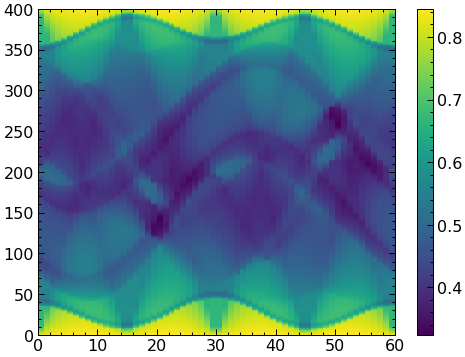

In [15]:
plt.pcolormesh(sino_prob)
plt.colorbar()

In [16]:
#PET_att_recon_GRIDREC = functions.compute_recon_tomopy(sino_att, thetas, 'gridrec', filter_name='hanning')
#PET_att_recon_MLEM = functions.compute_recon_tomopy(sino_att, thetas, 'mlem', num_iter=40)
#PET_att_recon_BART = functions.compute_recon_tomopy(sino_att, thetas, 'bart', num_iter=100)
PET_att_recon_OSEM = functions.compute_recon_tomopy(sino_att/sino_prob, thetas, 'osem', num_iter=60, num_block=1)

Reconstructing 1 slice groups with 1 master threads...


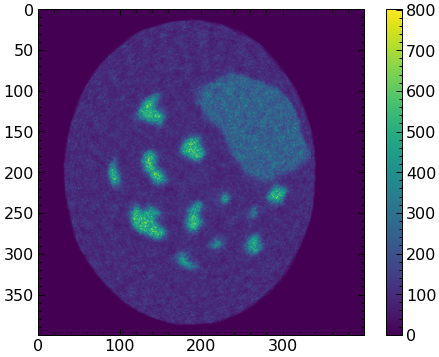

In [17]:
plt.imshow(PET_att_recon_OSEM)
plt.colorbar()

# Results from All Algorithms

In [18]:
def get_iters_MSEs(df, name):
    iters = np.array(df[name][0].strip('][').replace('\n', '').split()).astype(float)
    MSE = np.array(df[name][1].strip('][').replace('\n', '').split()).astype(float)
    var = np.array(df[name][2].strip('][').replace('\n', '').split()).astype(float)
    bias = np.array(df[name][3].strip('][').replace('\n', '').split()).astype(float)
    iter_best = int(df[name][5])
    MSE_best = MSE[iters==iter_best][0]
    return iters, MSE, var, bias, MSE_best

def info_dict(df):
    algos = list(df.columns[1:])
    di = {}
    for algo in algos:
        iters, mses, var, bias, mse_best = get_iters_MSEs(df, algo)
        di[algo] = {'iters': iters, 'mses': mses, 'vars':var, 'bias':bias, 'mse_best': mse_best}

    rmse_best = []
    for algo in algos:
        rmse_best.append(np.sqrt(di[algo]['mse_best']))
    return algos, rmse_best, di

def info_dict_livback(df):
    algos = list(df.columns[1:])
    di = {}
    for algo in algos:
        iters = df[algo]['n_iter']
        mse_best = df[algo]['data']['T']['MSE']
        di[algo] = {'iters': iters, 'data': data, 'mse_best': mse_best}

    rmse_best = []
    for algo in algos:
        rmse_best.append(np.sqrt(di[algo]['data']['T']['mse_best']))
    return algos, rmse_best, di

In [19]:
df1 = pd.read_pickle('all_algos_P1_livback.pkl')
df2 = pd.read_pickle('all_algos_P1_nlm_livback.pkl')
'''
df2 = pd.read_csv('all_algos_P2_livback.csv')
algos2, rmse_best2, di2 = info_dict(df2)
df3 = pd.read_csv('all_algos_P3.csv')
algos3, rmse_best3, di3 = info_dict(df3)
df4 = pd.read_csv('all_algos_P4.csv')
algos4, rmse_best4, di4 = info_dict(df4)
'''

"\ndf2 = pd.read_csv('all_algos_P2_livback.csv')\nalgos2, rmse_best2, di2 = info_dict(df2)\ndf3 = pd.read_csv('all_algos_P3.csv')\nalgos3, rmse_best3, di3 = info_dict(df3)\ndf4 = pd.read_csv('all_algos_P4.csv')\nalgos4, rmse_best4, di4 = info_dict(df4)\n"

In [20]:
algos = ['art', 'bart', 'mlem', 'osem', 'ospml_hybrid', 'ospml_quad', 'pml_hybrid', 'pml_quad', 'sirt', 'tv']

In [21]:
linestyles = ['--', ':']

styles = [
    r'$\lambda$',
    r'$\bowtie$',
    r'$\circlearrowleft$',
    r'$\clubsuit$',
    r'$\checkmark$']

colors = ('b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'grey', 'pink')

In [22]:
algo = 'tv'

In [23]:
T_val = 500
L_val = 250
B_val = 100

In [29]:
dp = 2

In [109]:
def plot_all_on_same(df, title):
    fig = plt.figure(figsize=(20,5))
    plt.subplot(133)
    [plt.plot(np.abs(df[algo]['data']['T']['BIAS'][dp:])/T_val*100, np.sqrt(df[algo]['data']['T']['VAR'][dp:])/T_val*100,
              marker=styles[i%len(styles)], color=colors[i%len(colors)], ls=linestyles[i%len(linestyles)], lw=1, label=algo) for i,algo in enumerate(algos)]
    plt.ylabel('$\sigma$ [%]', fontsize=20)
    plt.xlabel('$|b|$ [%]', fontsize=20)
    plt.title(r'Tumours')
    plt.grid()
    plt.legend(ncol=2, fontsize=10, facecolor='white', framealpha=1, frameon=True, loc='upper right')
    plt.ylim(8,16)
    plt.xlim(6,28)

    plt.subplot(132)
    [plt.plot(np.abs(df[algo]['data']['L']['BIAS'][dp:])/L_val*100,  np.sqrt(df[algo]['data']['L']['VAR'][dp:])/L_val*100,
              marker=styles[i%len(styles)], color=colors[i%len(colors)], ls=linestyles[i%len(linestyles)], lw=1, label=algo) for i,algo in enumerate(algos)]
    plt.ylabel('$\sigma$ [%]', fontsize=20)
    plt.xlabel('$|b|$ [%]', fontsize=20)
    plt.title(r'Liver')
    plt.grid()
    plt.ylim(9,18)
    plt.xlim(0,7)

    plt.subplot(131)
    [plt.plot(np.abs(df[algo]['data']['B']['BIAS'][dp:])/B_val*100,  np.sqrt(df[algo]['data']['B']['VAR'][dp:])/B_val*100,
              marker=styles[i%len(styles)], color=colors[i%len(colors)], ls=linestyles[i%len(linestyles)], lw=1, label=algo) for i,algo in enumerate(algos)]
    plt.ylabel('$\sigma$ [%]', fontsize=20)
    plt.xlabel('$|b|$ [%]', fontsize=20)
    plt.title(r'Background')
    plt.ylim(18,46)
    plt.xlim(2,11)
    
    plt.grid()
    fig.suptitle(title, fontsize=20, y=1.05)
    fig.tight_layout()

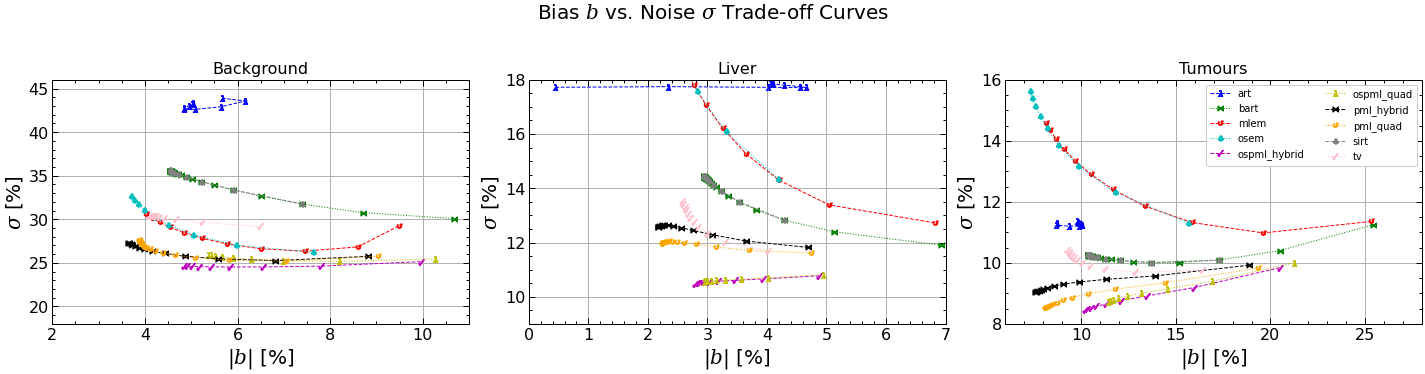

In [110]:
plot_all_on_same(df1, 'Bias $b$ vs. Noise $\sigma$ Trade-off Curves')
plt.savefig('images/bias_noise_tradeoff.png', dpi=200)
plt.show()

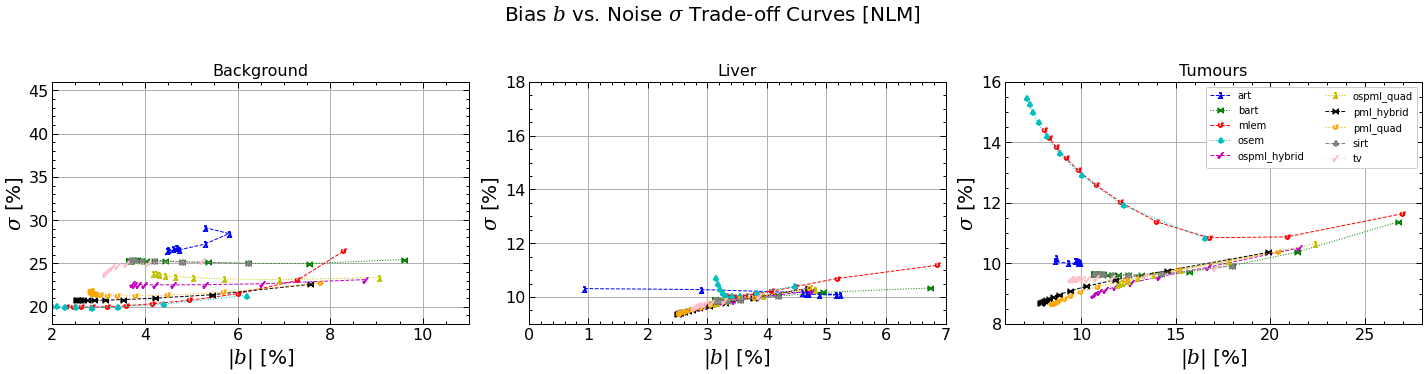

In [111]:
plot_all_on_same(df2, 'Bias $b$ vs. Noise $\sigma$ Trade-off Curves [NLM]')
plt.savefig('images/bias_noise_NLM_tradeoff.png', dpi=200)
plt.show()

In [108]:
for algo in algos:
    print('------------------')
    print(algo)
    print('------------------')
    for letter, val in zip(['Background', 'Liver', 'Tumour'], [B_val, L_val, T_val]):
        print(letter)
        bias_o = np.mean(np.array(np.abs(df1[algo]['data'][letter[0]]['BIAS']))/val*100)
        bias_n = np.mean(np.array(np.abs(df2[algo]['data'][letter[0]]['BIAS']))/val*100)
        std_o = np.mean(np.array(np.sqrt(df1[algo]['data'][letter[0]]['VAR']))/val *100)
        std_n = np.mean(np.array(np.sqrt(df2[algo]['data'][letter[0]]['VAR']))/val *100)
        print(f'Bias original {bias_o:.2f}% Bias new {bias_n:.2f}% Bias Rel Diff {(bias_n-bias_o):.2f}%')
        print(f'Var original {std_o:.2f}% Var new {std_n:.2f}% Var Rel Diff {(std_n-std_o):.2f}%')

------------------
art
------------------
Background
Bias original 4.75% Bias new 4.48% Bias Rel Diff -0.27%
Var original 43.45% Var new 27.75% Var Rel Diff -15.69%
Liver
Bias original 4.56% Bias new 5.12% Bias Rel Diff 0.56%
Var original 17.86% Var new 10.23% Var Rel Diff -7.63%
Tumour
Bias original 10.23% Bias new 10.15% Bias Rel Diff -0.08%
Var original 11.29% Var new 10.07% Var Rel Diff -1.21%
------------------
bart
------------------
Background
Bias original 5.47% Bias new 4.56% Bias Rel Diff -0.91%
Var original 33.64% Var new 25.06% Var Rel Diff -8.58%
Liver
Bias original 5.54% Bias new 5.69% Bias Rel Diff 0.14%
Var original 13.58% Var new 9.80% Var Rel Diff -3.78%
Tumour
Bias original 14.81% Bias new 15.36% Bias Rel Diff 0.55%
Var original 10.67% Var new 10.28% Var Rel Diff -0.39%
------------------
mlem
------------------
Background
Bias original 6.12% Bias new 4.72% Bias Rel Diff -1.40%
Var original 27.77% Var new 21.55% Var Rel Diff -6.22%
Liver
Bias original 8.16% Bias new 

In [44]:
dfs = [df1, df2]
types = ['T','L','B']
labels = ['Normal', 'NLM']

def make_subplot(typ, norm):
    for (i,df) in enumerate(dfs):
        plt.plot(np.abs(df[algo]['data'][typ]['BIAS'][1:])/norm, np.sqrt(df[algo]['data'][typ]['VAR'][1:])/norm,
                  marker=styles[i%len(styles)], color=colors[i%len(colors)], ls=linestyles[i%len(linestyles)], lw=1, label=labels[i])
        plt.ylabel('$\sigma$ [%]', fontsize=20)
        plt.xlabel('$|b|$ [%]', fontsize=20)
        plt.grid()

for algo in algos:
        
    fig = plt.figure(figsize=(13,4))
    plt.subplot(133)
    make_subplot('T', T_val/100)
    plt.title(r'Tumours')
    
    plt.subplot(132)
    make_subplot('L', L_val/100)
    plt.title(r'Liver')

    plt.subplot(131)
    make_subplot('B', B_val/100)
    plt.title(r'Background')
    plt.legend(ncol=1, fontsize=12, facecolor='white', framealpha=1, frameon=True, loc='best')


    fig.suptitle(f'{algo}: Bias $b$ vs.Spread $\sigma$ During Optimization', fontsize=20)
    fig.tight_layout()
    fig.patch.set_facecolor('white')
    plt.savefig(f'images/BIAS_VARIANCE_NLM/{algo}.png', dpi=200)
    plt.close()

<ipython-input-41-28e4b36db41d>:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("plasma").copy()
  cmap.set_under(color='black')


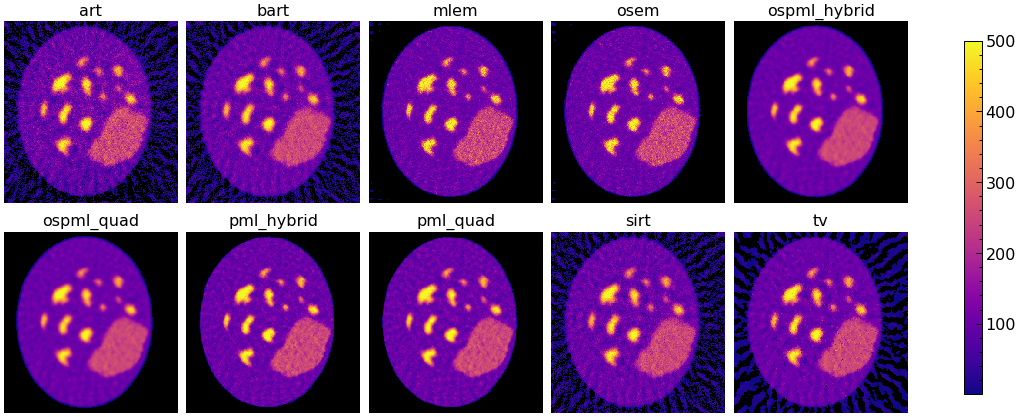

In [41]:
cmap = mpl.cm.get_cmap("plasma")
cmap.set_under(color='black')
fig, axes = plt.subplots(2,5,figsize=(16,6))
for i,algo in enumerate(algos):
    ax = axes.ravel()[i]
    ax.set_title(algo)
    pcm = ax.pcolormesh(df1[algo]['im_bests'][0], vmin=1, vmax=500, cmap=cmap)
    ax.set_axis_off()
fig.tight_layout()
fig.colorbar(pcm, ax=axes, shrink=0.9)
plt.savefig('images/recon.png', dpi=200)

Corrected using NLM

<ipython-input-92-0628240e653c>:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("plasma").copy()
  cmap.set_under(color='black')


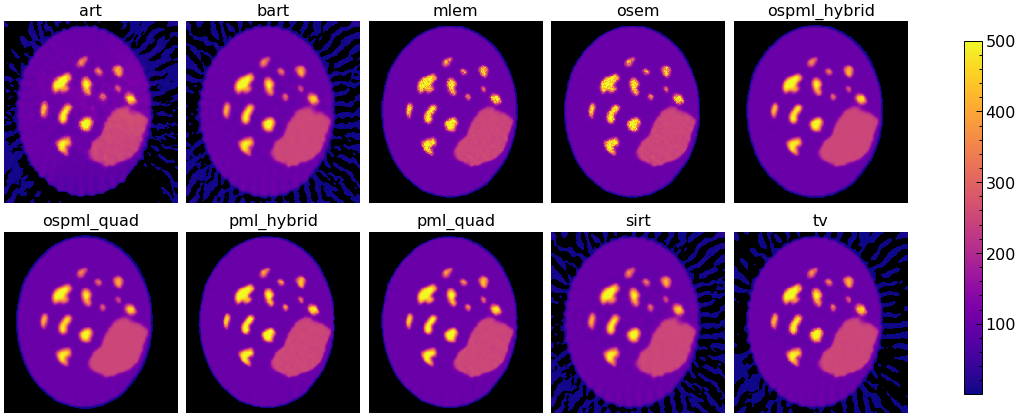

In [92]:
cmap = mpl.cm.get_cmap("plasma")
cmap.set_under(color='black')
fig, axes = plt.subplots(2,5,figsize=(16,6))
for i,algo in enumerate(algos):
    ax = axes.ravel()[i]
    ax.set_title(algo)
    pcm = ax.pcolormesh(df2[algo]['im_bests'][0], vmin=1, vmax=500, cmap=cmap)
    ax.set_axis_off()
fig.tight_layout()
fig.colorbar(pcm, ax=axes, shrink=0.9)
plt.savefig('images/recon_NLM.png', dpi=200)

In [80]:
for algo in df1.keys():
    np.savez("images/algo_images_P1/{}.npz".format(algo), img=df1[algo]['im_bests'][0])

For SNMMI Abstract:

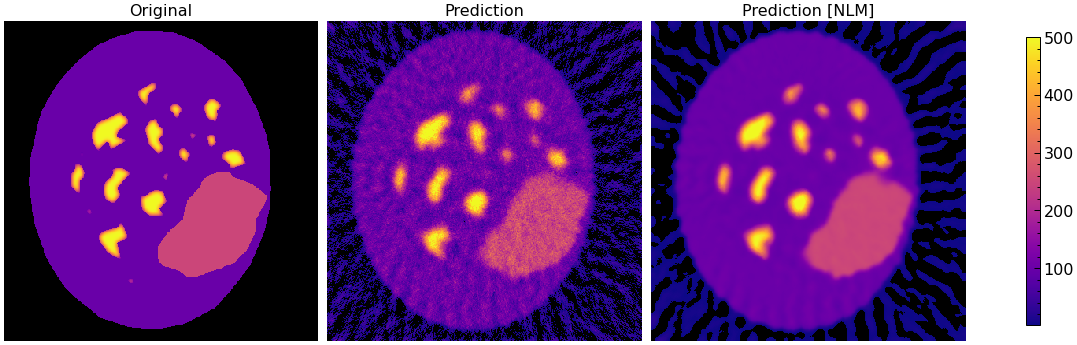

In [90]:
fig, ax = plt.subplots(1, 3, figsize=(17,5))
pcm = ax[0].pcolormesh(500*U, vmin=1, vmax=500, cmap=cmap)
ax[0].set_axis_off()
pcm = ax[1].pcolormesh(df1['sirt']['im_bests'][0], vmin=1, vmax=500, cmap=cmap)
ax[1].set_axis_off()
pcm = ax[2].pcolormesh(df2['sirt']['im_bests'][0], vmin=1, vmax=500, cmap=cmap)
ax[2].set_axis_off()
ax[0].set_title('Original')
ax[1].set_title('Prediction')
ax[2].set_title('Prediction [NLM]')
fig.tight_layout()
fig.colorbar(pcm, ax=ax, shrink=0.9)
plt.savefig('images/sirt_samp.png', dpi=200)

# Partial Volume Correction

In [99]:
import importlib
import paper_f_old as pfo 
import paper_f_newnew as pfn 
from skimage.restoration import denoise_nl_means, estimate_sigma, richardson_lucy, unsupervised_wiener, wiener
importlib.reload(pfo)
importlib.reload(pfn)

<module 'paper_f_newnew' from 'C:\\Users\\lukep\\Documents\\videos\\School\\Phys 541\\final_proj\\paper_f_newnew.py'>

Load one of the images from the last section

In [225]:
img = np.load('images/algo_images_P1/pml_quad.npz')['img']
img_nlm = denoise_nl_means(img, patch_size=10, patch_distance=30, h=30)

In [130]:
img_rl = richardson_lucy(img, get_gaus_kernel(9, 2.5), iterations=30, clip=False)

In [131]:
img_us = unsupervised_wiener(img, get_gaus_kernel(9, 2.5), clip=False)

In [132]:
img_w = wiener(img, get_gaus_kernel(9, 5), balance=10, clip=False)

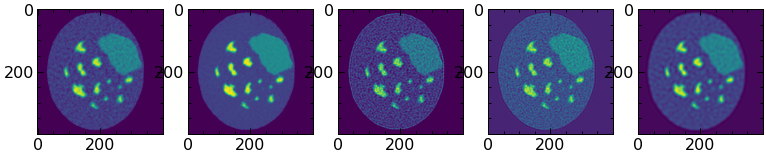

In [185]:
fig, ax = plt.subplots(1,5,figsize=(13,3))
ax[0].imshow(img)
ax[1].imshow(img_nlm)
ax[2].imshow(img_rl)
ax[3].imshow(img_us[0])
ax[4].imshow(img_w)

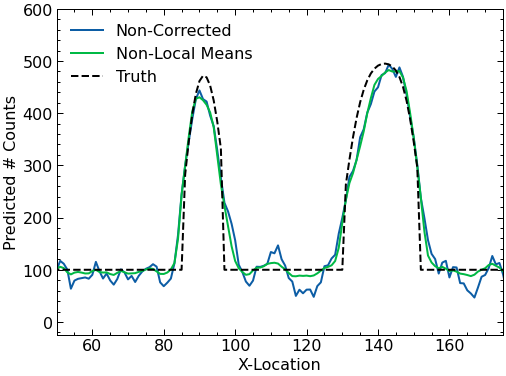

In [186]:
slc = 200
plt.plot(img[slc], label='Non-Corrected')
plt.plot(img_nlm[slc], label='Non-Local Means')
#plt.plot(img_us[0][slc])
#plt.plot(img_w[slc])
plt.plot(500*U[slc], ls='--', color='k', label='Truth')
plt.xlim(50,175)
plt.ylim(top=600)
plt.xlabel('X-Location')
plt.ylabel('Predicted # Counts')
plt.legend()

In [191]:
lam = U[T].ravel()*500 #original distribution
n_hat_raw = img[T]
n_hat_paper = img_us[0][T].ravel()

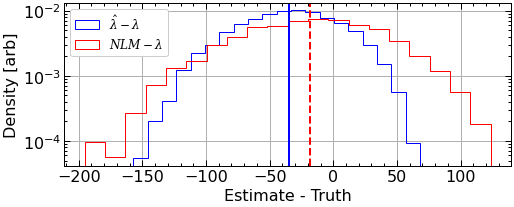

In [192]:
plt.figure(figsize=(8,3))
plt.hist(n_hat_raw-lam, color='blue', histtype='step', bins=20, label='$\hat{\lambda}-\lambda$', density=True)
plt.hist(n_hat_paper-lam, color='red', histtype='step', bins=20, label='$NLM-\lambda$', density=True)
plt.axvline(np.mean(n_hat_raw-lam), color='blue')
plt.axvline(np.mean(n_hat_paper-lam), color='red', ls='--')
plt.legend(ncol=1, fontsize=12, facecolor='white', framealpha=1, frameon=True, loc='upper left')
plt.xlabel('Estimate - Truth')
plt.ylabel('Density [arb]')
plt.grid()
plt.semilogy()
plt.show()

In [195]:
img_w = wiener(img, get_gaus_kernel(9, 5), balance=10, clip=False)

In [226]:
for name, A in zip(['tumour', 'liver', 'background'], [T, L, B]):
    lam = U[A].ravel()*500 #original distribution
    n_hat_raw = img[A]
    n_hat_paper = img_nlm[A].ravel()
    print('')
    print(name)
    print('---')
    print('Sigma')
    print(f'Original: {np.std(n_hat_raw-lam)}, New: {np.std(n_hat_paper-lam)}')
    print('Bias')
    print(f'Original: {np.mean(n_hat_raw-lam)}, New: {np.mean(n_hat_paper-lam)}')
    print('RMSE')
    print(f'Original: {np.sqrt(np.mean((n_hat_raw-lam)**2))}, New: {np.sqrt(np.mean((n_hat_paper-lam)**2))}')


tumour
---
Sigma
Original: 37.51867860248074, New: 35.33896717960123
Bias
Original: -34.515654316724266, New: -37.713908477942816
RMSE
Original: 50.98020828701912, New: 51.68347408992143

liver
---
Sigma
Original: 28.163143074197873, New: 16.636876816298
Bias
Original: -5.223908992696661, New: -5.399863094135901
RMSE
Original: 28.64353073525882, New: 17.49126043588868

background
---
Sigma
Original: 27.299257634184904, New: 18.128929505545475
Bias
Original: 3.2310001121733616, New: 2.6288837299351426
RMSE
Original: 27.489794999280498, New: 18.318545648674046


Find out which Wiener params are best

In [234]:
balances = np.linspace(1,50,30)
rmses = []
for balance in balances:
    img_w = wiener(img, get_gaus_kernel(9, 0.5), balance=balance, clip=False)
    lam = U[A].ravel()*500 #original distribution
    n_hat_raw = img[A]
    n_hat_paper = img_w[A].ravel()
    rmses.append(np.sqrt(np.mean((n_hat_paper-lam)**2)))
balances = np.array(balances)
rmses = np.array(rmses)

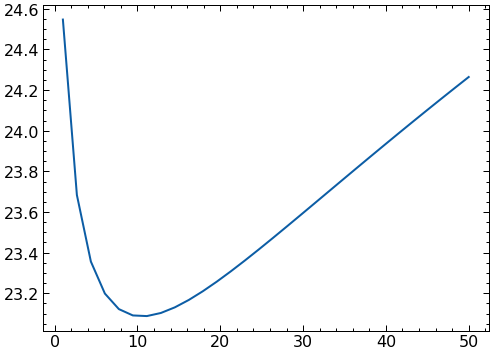

In [235]:
plt.plot(balances, rmses)

In [213]:
balances[np.argmin(rmses)]

14.517241379310345

In [232]:
stds = np.linspace(0.1,0.5,20)
rmses = []
for std in stds:
    img_w = wiener(img, get_gaus_kernel(9, std), balance=4, clip=False)
    lam = U[A].ravel()*500 #original distribution
    n_hat_raw = img[A]
    n_hat_paper = img_w[A].ravel()
    rmses.append(np.sqrt(np.mean((n_hat_paper-lam)**2)))
stds = np.array(stds)
rmses = np.array(rmses)

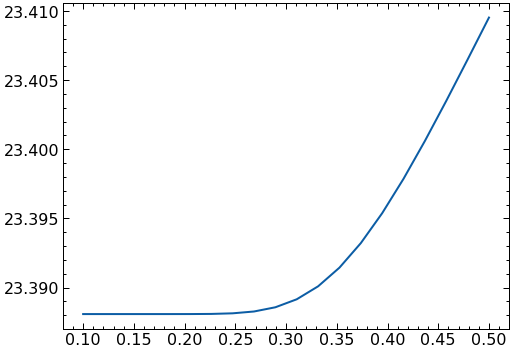

In [233]:
plt.plot(stds, rmses)

# Analyzing all PVC images

In [60]:
lam = U[T].ravel()*500 #original distribution

In [79]:
imgs = {}
rmses = {}
biass = {}
varss = {}
for algo in ['art', 'bart', 'mlem', 'osem', 'ospml_hybrid', 'ospml_quad', 'pml_hybrid', 'pml_quad', 'sirt', 'tv']:
    
    img_raw = np.load('images/algo_images_P1/{}.npz'.format(algo))['img']
    img_paper = np.load('images/algo_images_P1/PVC/{}.npz'.format(algo))['img']
    
    n_hat_raw = img_raw[T]
    n_hat_paper = img_paper[T]
    rmses[algo] = {'Raw': np.sqrt(np.mean((n_hat_raw-lam)**2)),
                   'PVC': np.sqrt(np.mean((n_hat_paper-lam)**2))}
    varss[algo] = {'Raw': np.var(n_hat_raw-lam),
                   'PVC': np.var(n_hat_paper-lam)}
    biass[algo] = {'Raw': np.mean(n_hat_raw-lam),
                   'PVC': np.mean(n_hat_paper-lam)}

In [95]:
rmses

{'art': {'Raw': 75.2669288038482, 'PVC': 67.56795842781227},
 'bart': {'Raw': 73.9988478771766, 'PVC': 69.02225369129512},
 'mlem': {'Raw': 132.7470797991379, 'PVC': 70.53681384631334},
 'osem': {'Raw': 132.7470797991379, 'PVC': 70.53681384631334},
 'ospml_hybrid': {'Raw': 82.33306538559927, 'PVC': 76.73038167328404},
 'ospml_quad': {'Raw': 84.3061988239741, 'PVC': 78.39705860731533},
 'pml_hybrid': {'Raw': 88.16356495487041, 'PVC': 69.51396442151024},
 'pml_quad': {'Raw': 79.26478196150167, 'PVC': 69.51090985326604},
 'sirt': {'Raw': 73.9898871027546, 'PVC': 68.79791598521749},
 'tv': {'Raw': 70.72908448441471, 'PVC': 69.85767947814765}}

In [96]:
pct_dffs_rmse

array([-10.2288887 ,  -6.72523198, -46.86375478, -46.86375478,
        -6.80490115,  -7.00914085, -21.15341019, -12.30542981,
        -7.01713615,  -1.23203207])

In [83]:
rmses_raw = np.array([rmses[key]['Raw'] for key in rmses.keys()])
rmses_pvc = np.array([rmses[key]['PVC'] for key in rmses.keys()])

vars_raw = np.array([varss[key]['Raw'] for key in rmses.keys()])
vars_pvc = np.array([varss[key]['PVC'] for key in rmses.keys()])

bias_raw = np.array([biass[key]['Raw'] for key in rmses.keys()])
bias_pvc = np.array([biass[key]['PVC'] for key in rmses.keys()])

In [90]:
pct_dffs_rmse = 100*(rmses_pvc - rmses_raw)/rmses_raw
pct_dffs_var = 100*(vars_pvc - vars_raw)/vars_raw
pct_dffs_bias = 100*(bias_pvc - bias_raw)/bias_raw

In [91]:
np.mean(pct_dffs_rmse)

-16.620368046407123

In [92]:
np.mean(pct_dffs_var)

11.018131663757845

In [93]:
np.mean(pct_dffs_bias)

-52.45872017342587